In [1]:
# cell for Google Colab ipynb opening

## %%capture
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
# !pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-2.2.0+cu121.html
# !pip install faiss-gpu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
from torch_geometric import EdgeIndex
from torch_geometric.utils import degree
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import MIPSKNNIndex
from torch_geometric.metrics import LinkPredMAP, LinkPredPrecision, LinkPredRecall
from torch_geometric.nn.models.lightgcn import BPRLoss

from tqdm import tqdm
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from utils.model import GNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
faiss_device = torch.device('cpu') # 'cuda' for Colab, 'cpu' for my Windows laptop

In [3]:
from utils.data_transformation import data_to_heterograph

data, users_rev_mapping, movies_rev_mapping =\
    data_to_heterograph('./data_processed/encoded_data.npz')
data

HeteroData(
  movie={ x=[11909, 200] },
  user={ x=[448798, 14] },
  (user, watched, movie)={
    edge_index=[2, 1288996],
    time=[1288996],
  },
  (movie, rev_watched, user)={
    edge_index=[2, 1288996],
    time=[1288996],
  }
)

In [4]:
# sparse interaction matrix
1288996 / (11909 * 448798)

0.0002411711540184161

## Train/test split

In [5]:
train_ratio = 0.8
train_size = int(train_ratio * data['user', 'movie'].num_edges)
watch_threshold = -1

edges = data['user', 'movie'].edge_index
time = data['user', 'movie'].time
num_users, num_movies = data['user'].num_nodes, data['movie'].num_nodes

loader_kwargs = dict(
    data=data, batch_size=1024,
    num_neighbors=[5, 5, 5],
    time_attr='time', temporal_strategy='last',
    num_workers=4)

train_loader = LinkNeighborLoader(
    edge_label_index=(('user', 'movie'), edges[:, :train_size]),
    edge_label_time=time[torch.arange(train_size)]-1,
    neg_sampling=dict(mode='binary', amount=1),
    shuffle=True,
    **loader_kwargs)

user_loader = NeighborLoader(
    input_nodes='user',
    input_time=(time[train_size]-1).repeat(num_users),
    **loader_kwargs)

movie_loader = NeighborLoader(
    input_nodes='movie',
    input_time=(time[train_size]-1).repeat(num_movies),
    **loader_kwargs)

sparse_size = (num_users, num_movies)
train_edges = EdgeIndex(edges[:, :train_size].contiguous().to(device),
                        sparse_size=sparse_size).sort_by('row').values
test_edges = EdgeIndex(edges[:, train_size:].contiguous().to(device),
                       sparse_size=sparse_size).sort_by('row').values

is_test_node = degree(train_edges[0], num_nodes=num_users) >= watch_threshold
test_edges = test_edges[:, is_test_node[test_edges[0]]]
train_edges = train_edges[:, is_test_node[train_edges[0]]]

## GNN

In [6]:
gnn_model = GNN(num_layers=3, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
# optimizer.load_state_dict(torch.load('./adam_state.pt'))
# gnn_model.load_state_dict(torch.load('./gnn_state.pt'))
# gnn_model.to(device)
bpr_loss = BPRLoss()
bceligits_loss = torch.nn.BCEWithLogitsLoss()

In [ ]:
from utils.data_transformation import sparse_batch_narrow
from torch.nn.modules.loss import _Loss

def train(_loss: _Loss):
    gnn_model.train()
    total_loss = total_examples = 0
    for batch in tqdm(train_loader):
        batch = batch.to(device)
        batch_size = len(batch['user', 'movie'].input_id)
        optimizer.zero_grad()

        out = gnn_model(batch.x_dict, batch.edge_index_dict,
                        batch['user', 'movie'].edge_label_index)

        if isinstance(_loss, BPRLoss):
            loss = _loss(out[:batch_size], out[batch_size:])
        else:
            target = batch['user', 'movie'].edge_label
            loss = _loss(out, target)

        loss.backward(); optimizer.step()

        total_loss += float(loss) * batch_size
        total_examples += batch_size

    return total_loss / total_examples

@torch.no_grad()
def test(test_edges: EdgeIndex, train_edges: EdgeIndex, k: int, top_count: int = None,
         filter_user: bool = False, is_test_node: torch.Tensor = None):
    
    if filter_user and not is_test_node:
        raise Exception('is_test_node needs to be specified if filter_user == True')

    gnn_model.eval()
    movie_embs = gnn_model.get_movies_embeddings(movie_loader, device)

    if top_count is None:
        movie_embs = torch.cat(movie_embs, dim=0)
    else:
        emb_size = movie_embs[0].size()[1]
        movie_embs.append(torch.zeros((1, emb_size), device=device))
        movie_embs = torch.cat(movie_embs, dim=0)
        top_indices = list(range(top_count)) + [len(movie_embs)-1]
        movie_embs = movie_embs[top_indices]
    
    mipsknn = MIPSKNNIndex(movie_embs.to(faiss_device))
    metrics = LinkPredMAP(k), LinkPredPrecision(k), LinkPredRecall(k)
    users_infered = 0
    for batch in user_loader:
        batch = batch.to(device)
        batch_size = batch['user'].batch_size
        batch_user_embs = gnn_model.encoder(batch.x_dict, batch.edge_index_dict)\
            ['user'][:batch_size].to(faiss_device)
        
        if filter_user:
            batch_user_embs = batch_user_embs[is_test_node[users_infered:users_infered+batch_size]]
            batch_test_edges = sparse_batch_narrow(test_edges, users_infered, batch_size)
            batch_train_edges = sparse_batch_narrow(train_edges, users_infered, batch_size)
        else:
            batch_test_edges = test_edges.sparse_narrow(0, users_infered, batch_size).to(faiss_device)
            batch_train_edges = train_edges.sparse_narrow(0, users_infered, batch_size).to(faiss_device)

        if top_count is not None:
            batch_test_edges[1, batch_test_edges[1] >= top_count] = top_count
            batch_train_edges[1, batch_train_edges[1] >= top_count] = top_count

        top_indices_mat = mipsknn.search(batch_user_embs, k, exclude_links=batch_train_edges)[1]
        for metric in metrics:
            metric.update(top_indices_mat.cpu(), batch_test_edges)

        users_infered += batch_size

    return tuple(float(metric.compute()) for metric in metrics)

k = 20
df_metrics = pd.DataFrame(columns=['loss', f'map@{k}', f'precision@{k}', f'recall@{k}'])
best_map = 0
best_state_dict = []
best_map = .0

In [ ]:
try:
    for epoch_num in range(1, 100):
        loss = train(bpr_loss)
        print(f'Train: Epoch №{epoch_num:02d}, Loss: {loss:.4f}')
        if epoch_num % 2 == 0:
            map, precision, recall = test(test_edges, train_edges, k, top_count=1000, filter_user=False)
            print('Test@%d, MAP: %.4f, Precision: %.4f, Recall: %.4f' % (k, map, precision, recall))
            df_metrics.loc[2*len(df_metrics), :] = [loss, map, precision, recall]
            if map > best_map:
                best_map = map
                best_state_dict = deepcopy(gnn_model.state_dict())

except KeyboardInterrupt:
  print('--KeyboardInterrupt--')

In [99]:
torch.save(best_state_dict, './model_saves/gnn_state.pt')
torch.save(optimizer.state_dict(), './model_saves/adam_state.pt')
df_metrics.to_csv('./model_saves/dnn_metrics.csv')

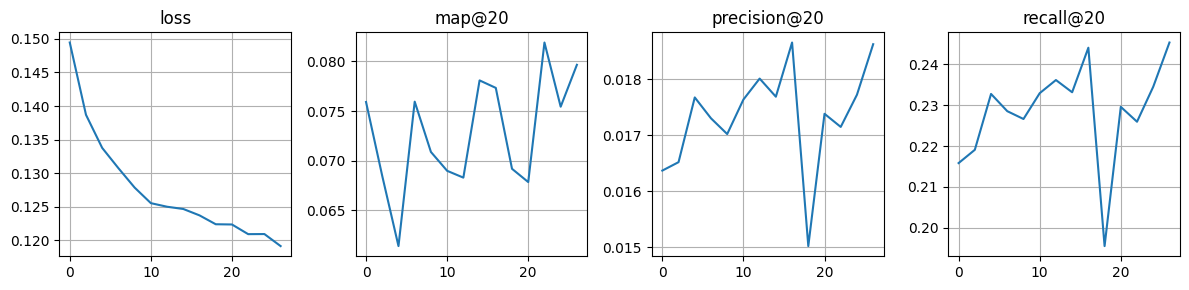

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, metric_name in enumerate(df_metrics.columns):
    df_metrics[metric_name].plot(ax=axes[i], grid=True, title=metric_name)
fig.tight_layout()

## Example of making recommendations by Graph Neural Network

In [9]:
%%capture
gnn_model = GNN(num_layers=3, hidden_channels=64)
gnn_model.load_state_dict(torch.load('./gnn_state.pt'))
gnn_model.to(device)

In [10]:
df_inter = pd.read_csv('data/processed/interactions.csv')
df_items = pd.read_csv('data/processed/items.csv')
df_users = pd.read_csv('data/processed/users.csv')

users_mapping = {user_id: idx for idx, user_id in users_rev_mapping.items()}
movies_mapping = {movie_id: idx for idx, movie_id in movies_rev_mapping.items()}
movies_id_to_df_idx = {movie_id: df_idx for df_idx, movie_id in df_items['item_id'].items()}

In [11]:
item_id = 13713
df_inter[df_inter['item_id'] == item_id]['user_id']

67771      148609
71584      625015
71925       66275
77383      740520
79778      705692
            ...  
1264765    672407
1265072    560584
1265139    925000
1282297    757110
1285436    381646
Name: user_id, Length: 444, dtype: int64

In [12]:
user_id = 148609
df_inter[df_inter['user_id'] == user_id].merge(df_items)

,user_id,item_id,last_watch_dt,watched_pct,content_type,title,genres,age_rating,keywords,views
0,148609,12395,2021-03-23,100.0,film,"Беги, мальчик, беги","боевики, драмы, биография, военные",16,"вторая мировая война, варшавское гетто, дети, ...",100
1,148609,13713,2021-04-01,0.0,film,Звёздные войны: Скрытая угроза,"боевики, фантастика, приключения",0,"пророчество, сенат, королева, надзиратель, гал...",444
2,148609,11885,2021-04-01,100.0,film,Хан Соло: Звёздные войны. Истории,"боевики, фантастика, приключения",12,"космический корабль, приквел, спин-офф, контра...",621
3,148609,13980,2021-04-11,100.0,film,Изгой-один: Звёздные войны. Истории.,"боевики, фантастика, приключения",16,"бунтарь, космический корабль, космическое сраж...",416


In [13]:
df_users[df_users['user_id'] == user_id]

,user_id,age,income,sex,kids_flg
80881,148609,age_45_54,income_20_40,М,0


In [100]:
users_idx = torch.tensor([users_mapping[user_id]])
with torch.no_grad():
    recs = gnn_model.recommend(users_idx, data,
        top_count=1000, k=20, device=device, faiss_device=faiss_device)
    
rec_ids = np.vectorize(movies_rev_mapping.get)(recs.squeeze())
rec_df_idx = np.vectorize(movies_id_to_df_idx.get)(rec_ids)
df_items.iloc[rec_df_idx].reset_index(drop=True).head()

,item_id,content_type,title,genres,age_rating,keywords,views
0,13865,film,Девятаев,"драмы, военные, приключения",12,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...",28375
1,7102,film,Дочь волка,"боевики, триллеры",18,"2019, канада, дочь, волка",4811
2,4151,series,Секреты семейной жизни,комедии,18,"брызги крови, кровь, жестокое обращение с живо...",19562
3,9728,film,Гнев человеческий,"боевики, триллеры",18,"ограбление, криминальный авторитет, месть, пер...",32953
4,7571,film,100% волк,"мультфильм, приключения, семейное, фэнтези, ко...",6,"пудель, подростковая тревога, оборотень, приня...",6805
